<h1>Image Cropping</h1>

Purpose is to walk through all the images and crop the images to a single face of the person of interest. Images are thrown out if no face can be detected. If there are multiple faces, the face closest to the center of the image is used.

In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

import os
import dlib
import fnmatch
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2grey
from skimage.transform import resize
from matplotlib.pyplot import imshow 
from scipy.spatial import distance
from skimage import io
from PIL import Image

<h2>Facial Feature Point Functions</h2>

In [3]:
DATA_PATH = '../../data/'
DATA_LFW_PATH = DATA_PATH + 'lfw/'
DATA_LFW_CROPPED_PATH = DATA_PATH + 'lfw_cropped/'

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(DATA_PATH + 'shape_predictor_68_face_landmarks.dat')

In [43]:
def get_centroid(points):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return (sum(x) / len(points), sum(y) / len(points))
    
def get_facial_feature_points(im, face):
    points = np.array([[p.x, p.y] for p in predictor(im, face).parts()])
    facial_feature_points = [None for i in range(5)]
    
    # Left and right eyes, nose, left and right points of the mouth
    facial_feature_points[0] = get_centroid(np.concatenate((points[37:39], points[40:42])))
    facial_feature_points[1] = get_centroid(np.concatenate((points[43:45], points[46:48])))
    facial_feature_points[2] = points[30]
    facial_feature_points[3] = points[48]
    facial_feature_points[4] = points[54]
    
    return np.array(facial_feature_points)

def get_facial_landmark_points(im, face, w=.7, eye_scale=.5):
    points = np.array([[p.x, p.y] for p in predictor(im, face).parts()])
    landmarks = [None for i in range(9)]
    
    dx = points[27][0] - points[28][0]
    dy = points[27][1] - points[28][1]

    landmarks[0] = points[19]
    
    p = get_centroid(points[40:42])
    landmarks[1] = (p[0] - dx * eye_scale, p[1] - dy * eye_scale)
    
    landmarks[2] = (points[3][0] * (1 - w) + w * points[31][0],
                      points[3][1] * (1 - w) + w * points[31][1])
    
    p = get_centroid([points[19], points[24]])
    landmarks[3] = (p[0] + dx * .5, p[1] + dy * .5)
    landmarks[4] = points[28]
    landmarks[5] = points[51]
    
    landmarks[6] = points[24]
    
    p = get_centroid(points[46:48])
    landmarks[7] = (p[0] - dx * eye_scale, p[1] - dy * eye_scale)
    
    landmarks[8] = (points[13][0] * (1 - w) + w * points[35][0],
                      points[13][1] * (1 - w) + w * points[35][1])
    
    return np.array(landmarks)

<h2>Extracting Images</h2>

In [7]:
files = []
for root, dirnames, filenames in os.walk(DATA_LFW_PATH):
    for filename in fnmatch.filter(filenames, '*'):
        if not filename.endswith('.DS_Store'):
            files.append(os.path.join(root, filename))

In [8]:
if not os.path.exists(DATA_LFW_CROPPED_PATH):
    os.makedirs(DATA_LFW_CROPPED_PATH)
    
for f in files:
    directory = os.path.dirname(f).replace('/lfw/', '/lfw_cropped/')
    if not os.path.exists(directory):
        os.makedirs(directory)

In [9]:
set([os.path.splitext(f)[1] for f in files])

{'.jpg'}

In [10]:
images = [io.imread(f) for f in files]

In [11]:
set([image.shape for image in images])

{(250, 250, 3)}

In [11]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2

num_images_no_faces_detected = 0
for f, img in zip(files, images):
    
    most_centre_face = None
    most_centre_dist = sys.maxint
        
    detected_faces = detector(img, 1)
    if len(detected_faces) == 0:
        num_images_no_faces_detected += 1
        continue
        
    for d in detected_faces:
        face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
        centre_dist = distance.euclidean(image_centre, face_centre)
        if centre_dist < most_centre_dist:
            most_centre_dist = centre_dist
            most_centre_face = d
    

    image = Image.open(f)  
    f = f.replace('/lfw/', '/lfw_cropped/')
    image_cropped = image.crop((most_centre_face.left(), 
                most_centre_face.top(), 
                most_centre_face.right(), 
                most_centre_face.bottom())
              )
    image_cropped.save(f)
    
    coords = get_facial_feature_points(img, most_centre_face)
    coords[:,0] -= most_centre_face.left()
    coords[:,1] -= most_centre_face.top()

    np.save(os.path.splitext(f)[0] + '.npy', coords)


<h2>Experimental code</h2>
Not actually run to produce the cropped images

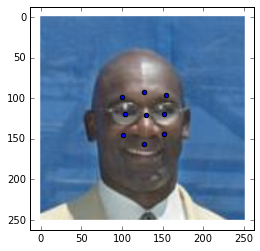

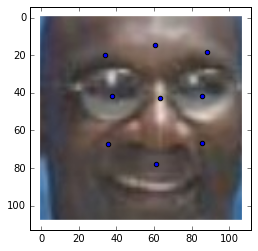

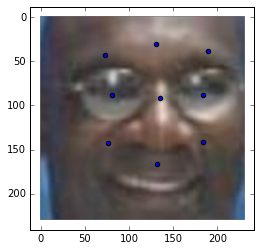

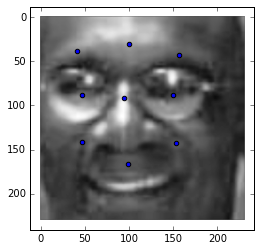

In [46]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2
most_centre_face = None
most_centre_dist = sys.maxint

i = 0
img = images[i]
image = Image.open(files[i]) 


detected_faces = detector(img, 1)

for d in detected_faces:
    face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
    centre_dist = distance.euclidean(image_centre, face_centre)
    if centre_dist < most_centre_dist:
        most_centre_dist = centre_dist
        most_centre_face = d

coords = get_facial_landmark_points(img, most_centre_face)
coord_transpose = np.transpose(coords)
imshow(img)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

# cropped image
img_cropped = image.crop((most_centre_face.left(), 
            most_centre_face.top(), 
            most_centre_face.right(), 
            most_centre_face.bottom()))
imshow(img_cropped)
coords[:,0] -= most_centre_face.left()
coords[:,1] -= most_centre_face.top()
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

f = f.replace('/lfw/', '/lfw_cropped/')
image.crop((most_centre_face.left(), 
            most_centre_face.top(), 
            most_centre_face.right(), 
            most_centre_face.bottom())
          ).save(f)

coord_file = os.path.splitext(f)[0] + '_landmarks.npy'
np.save(coord_file, coords)

# scale coordinates for image resize
resize_shape = (230, 230, 3)
input_shape = io.imread(f).shape
resized_image = resize(io.imread(f), resize_shape)
imshow(resized_image)

scale = np.array(resize_shape).astype(float) / np.array(input_shape)
coords[:,0] = coords[:,0] * scale[1]
coords[:,1] = coords[:,1] * scale[0]
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

def reflection(image):
    image = np.array([list(reversed(row)) for row in image])
    return image

imshow(reflection(rgb2grey(resized_image)), cmap='Greys_r')
coords = [(resize_shape[1] - coord[0], coord[1]) for coord in coords]
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

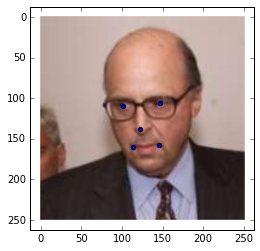

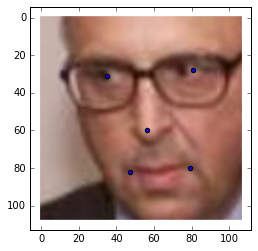

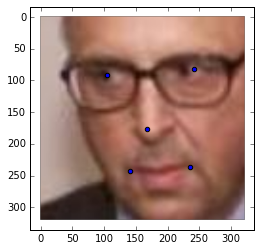

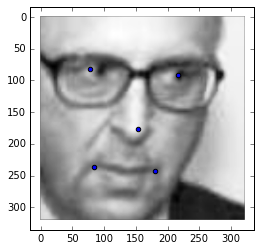

In [28]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2
most_centre_face = None
most_centre_dist = sys.maxint

i = 100
img = images[i]
image = Image.open(files[i]) 


detected_faces = detector(img, 1)

for d in detected_faces:
    face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
    centre_dist = distance.euclidean(image_centre, face_centre)
    if centre_dist < most_centre_dist:
        most_centre_dist = centre_dist
        most_centre_face = d

coords = get_facial_feature_points(img, most_centre_face)
coord_transpose = np.transpose(coords)
imshow(img)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

img_cropped = image.crop((most_centre_face.left(), 
            most_centre_face.top(), 
            most_centre_face.right(), 
            most_centre_face.bottom()))
imshow(img_cropped)
coords[:,0] -= most_centre_face.left()
coords[:,1] -= most_centre_face.top()

coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

f = f.replace('/lfw/', '/lfw_cropped/')
image.crop((most_centre_face.left(), 
            most_centre_face.top(), 
            most_centre_face.right(), 
            most_centre_face.bottom())
          ).save(f)

coord_file = os.path.splitext(f)[0] + '.npy'
np.save(coord_file, coords)

# scale coordinates for image resize
resize_shape = (320, 320, 3)
input_shape = io.imread(f).shape
resized_image = resize(io.imread(f), resize_shape)
imshow(resized_image)

scale = np.array(resize_shape).astype(float) / np.array(input_shape)
coords[:,0] = coords[:,0] * scale[1]
coords[:,1] = coords[:,1] * scale[0]
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

def reflection(image):
    image = np.array([list(reversed(row)) for row in image])
    return image

imshow(reflection(rgb2grey(resized_image)), cmap='Greys_r')
coords = [(resize_shape[1] - coord[0], coord[1]) for coord in coords]
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()